# **Part-1: Data Collection and Preprocessing**

# Pre-requisite

**CHEMBL DATABASE:**

The [ChEMBL](https://www.ebi.ac.uk/chembl/) is a database of bioactive drug-like small molecules, it contains 2-D structures, calculated properties (e.g. logP, Molecular Weight, Lipinski Parameters, etc.) and abstracted bioactivities (e.g. binding constants, pharmacology and ADMET data). It consists of more than 2.1 million compounds compiled from around 80000 documents, 1.4 million assays with spanning 2000 cells, 14000 targets and 38000 indicators.

## Installing libraries

In [1]:
# Installing the CHEMBL Web Package Service to retrieve data from CHEMBL Database
! pip install chembl_webresource_client

     |████████████████████████████████| 61kB 3.1MB/s 


## Importing Libraries

In [2]:
# Importing the necessary libraries
import pandas as pd
from chembl_webresource_client.new_client import new_client

# Data Collection

## Searching for the target protein

In [3]:
# Target Search for alzheimer's disease
target = new_client.target
target_query = target.search('acetylcholinesterase')
targets = pd.DataFrame.from_dict(target_query)
targets[:10]

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P22303', 'xref_name': None, 'xre...",Homo sapiens,Acetylcholinesterase,27.0,False,CHEMBL220,"[{'accession': 'P22303', 'component_descriptio...",SINGLE PROTEIN,9606
1,[],Homo sapiens,Cholinesterases; ACHE & BCHE,27.0,False,CHEMBL2095233,"[{'accession': 'P06276', 'component_descriptio...",SELECTIVITY GROUP,9606
2,[],Drosophila melanogaster,Acetylcholinesterase,17.0,False,CHEMBL2242744,"[{'accession': 'P07140', 'component_descriptio...",SINGLE PROTEIN,7227
3,"[{'xref_id': 'P04058', 'xref_name': None, 'xre...",Torpedo californica,Acetylcholinesterase,15.0,False,CHEMBL4780,"[{'accession': 'P04058', 'component_descriptio...",SINGLE PROTEIN,7787
4,"[{'xref_id': 'P21836', 'xref_name': None, 'xre...",Mus musculus,Acetylcholinesterase,15.0,False,CHEMBL3198,"[{'accession': 'P21836', 'component_descriptio...",SINGLE PROTEIN,10090
5,"[{'xref_id': 'P37136', 'xref_name': None, 'xre...",Rattus norvegicus,Acetylcholinesterase,15.0,False,CHEMBL3199,"[{'accession': 'P37136', 'component_descriptio...",SINGLE PROTEIN,10116
6,"[{'xref_id': 'O42275', 'xref_name': None, 'xre...",Electrophorus electricus,Acetylcholinesterase,15.0,False,CHEMBL4078,"[{'accession': 'O42275', 'component_descriptio...",SINGLE PROTEIN,8005
7,"[{'xref_id': 'P23795', 'xref_name': None, 'xre...",Bos taurus,Acetylcholinesterase,15.0,False,CHEMBL4768,"[{'accession': 'P23795', 'component_descriptio...",SINGLE PROTEIN,9913
8,[],Anopheles gambiae,Acetylcholinesterase,15.0,False,CHEMBL2046266,"[{'accession': 'Q869C3', 'component_descriptio...",SINGLE PROTEIN,7165
9,[],Bemisia tabaci,AChE2,15.0,False,CHEMBL2366409,"[{'accession': 'B3SST5', 'component_descriptio...",SINGLE PROTEIN,7038


In [4]:
targets.shape

(24, 9)

## Select and Retrieve Data with target_type == SINGLE PROTEIN and standard_type == IC<sub>50</sub> measured in nM(nano molar)

Formely known as PROTEIN in the target type, it is now subdivded into a number of categories:


*   In the simple case where a compound is believed to interact specifically with a monomeric protein, the target type ‘SINGLE PROTEIN’ is now used. 


*   In cases where either a compound is known to act non-specifically with all members of a protein family, or the assay conditions are such that it is not possible to determine which member(s) of a protein family the compound is acting on (e.g. a cell-based or tissue-based assay), a target type of ‘PROTEIN FAMILY’ is used.



*   If the molecular entity of a compound is known as protein complex and can be precisely defined; with which the our compound interacts, the target type ‘PROTEIN COMPLEX’ is used. 



*   In a tissue-based format, the exact subunit combinations present are generally not known. In such cases, the target type of ‘PROTEIN COMPLEX GROUP’ is used.



*   Other new target types have also been created for approved drugs whose molecular targets are not proteins, e.g. metals.






In [5]:
# Assigning the selected target as entry 1
selected_target = targets.target_chembl_id[0]
selected_target

'CHEMBL220'

When identifying compounds that bind to a particular protein target for structure–activity relationship or lead identification studies, it is important to be using comparable data. Thus, for this analysis we are using the standardized value of IC<sub>50</sub> with the units as nM, i.e. nano molars.

In [6]:
# Retriving the bioactivity data with target_type as SINGLE PROTEIN as well as standard type as IC50.
activity = new_client.activity
result = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [7]:
# Converting dictionary to dataframe
df = pd.DataFrame.from_dict(result)
df.head(3)

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,33969,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '19.61', 'le': '0.36', 'lle': '3.32', ...",CHEMBL133897,None,CHEMBL133897,6.12,False,http://www.openphacts.org/units/Nanomolar,252547,=,1,True,=,None,IC50,nM,None,750.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.75
1,None,37563,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '18.57', 'le': '0.38', 'lle': '2.45', ...",CHEMBL336398,None,CHEMBL336398,7.00,False,http://www.openphacts.org/units/Nanomolar,252533,=,1,True,=,None,IC50,nM,None,100.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.1
2,None,37565,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,None,CHEMBL131588,None,CHEMBL131588,None,False,http://www.openphacts.org/units/Nanomolar,252530,>,1,True,>,None,IC50,nM,None,50000.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,50.0


In [8]:
# Getting the shape of the dataframe created
df.shape

(7479, 45)

In [9]:
# Saving the dataframe to a csv file
df.to_csv('bioactivity_data_raw.csv',index=False)

## Handling Missing Data

In [12]:
# Dropping the compounds having missing values for the standard_type and canonical_smiles
df1 = df[df.standard_value.notna()]
df2 = df1[df1.canonical_smiles.notna()]
df2

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,33969,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '19.61', 'le': '0.36', 'lle': '3.32', ...",CHEMBL133897,None,CHEMBL133897,6.12,False,http://www.openphacts.org/units/Nanomolar,252547,=,1,True,=,None,IC50,nM,None,750.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.75
1,None,37563,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '18.57', 'le': '0.38', 'lle': '2.45', ...",CHEMBL336398,None,CHEMBL336398,7.00,False,http://www.openphacts.org/units/Nanomolar,252533,=,1,True,=,None,IC50,nM,None,100.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.1
2,None,37565,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,None,CHEMBL131588,None,CHEMBL131588,None,False,http://www.openphacts.org/units/Nanomolar,252530,>,1,True,>,None,IC50,nM,None,50000.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,50.0
3,None,38902,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '16.11', 'le': '0.34', 'lle': '1.81', ...",CHEMBL130628,None,CHEMBL130628,6.52,False,http://www.openphacts.org/units/Nanomolar,252534,=,1,True,=,None,IC50,nM,None,300.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.3
4,None,41170,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '17.60', 'le': '0.36', 'lle': '3.00', ...",CHEMBL130478,None,CHEMBL130478,6.10,False,http://www.openphacts.org/units/Nanomolar,252552,=,1,True,=,None,IC50,nM,None,800.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7474,None,19468459,[],CHEMBL4478126,Inhibition of human erythrocyte AChE using ATC...,B,None,None,BAO_0000190,BAO_0000357,single protein format,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C(F)(F)F)CC3...,None,None,CHEMBL4477206,J Med Chem,2016.0,"{'bei': '9.32', 'le': '0.18', 'lle': '-2.84', ...",CHEMBL4533844,None,CHEMBL4533844,5.12,False,http://www.openphacts.org/units/Nanomolar,3255436,=,1,True,=,None,IC50,nM,None,7570.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,7.57
7475,None,19468460,[],CHEMBL4478126,Inhibition of human erythrocyte AChE using ATC...,B,None,None,BAO_0000190,BAO_0000357,single protein format,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C)CC3)sc2-c2...,None,None,CHEMBL4477206,J 

In [13]:
# Dropping the duplicates
df3 = df2.drop_duplicates(['canonical_smiles'])
df3

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,33969,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '19.61', 'le': '0.36', 'lle': '3.32', ...",CHEMBL133897,None,CHEMBL133897,6.12,False,http://www.openphacts.org/units/Nanomolar,252547,=,1,True,=,None,IC50,nM,None,750.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.75
1,None,37563,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '18.57', 'le': '0.38', 'lle': '2.45', ...",CHEMBL336398,None,CHEMBL336398,7.00,False,http://www.openphacts.org/units/Nanomolar,252533,=,1,True,=,None,IC50,nM,None,100.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.1
2,None,37565,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,None,CHEMBL131588,None,CHEMBL131588,None,False,http://www.openphacts.org/units/Nanomolar,252530,>,1,True,>,None,IC50,nM,None,50000.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,50.0
3,None,38902,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '16.11', 'le': '0.34', 'lle': '1.81', ...",CHEMBL130628,None,CHEMBL130628,6.52,False,http://www.openphacts.org/units/Nanomolar,252534,=,1,True,=,None,IC50,nM,None,300.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.3
4,None,41170,[],CHEMBL643384,Inhibitory concentration against acetylcholine...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,None,None,CHEMBL1148382,J. Med. Chem.,2004.0,"{'bei': '17.60', 'le': '0.36', 'lle': '3.00', ...",CHEMBL130478,None,CHEMBL130478,6.10,False,http://www.openphacts.org/units/Nanomolar,252552,=,1,True,=,None,IC50,nM,None,800.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7473,None,19468458,[],CHEMBL4478126,Inhibition of human erythrocyte AChE using ATC...,B,None,None,BAO_0000190,BAO_0000357,single protein format,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4cccc(F)c4)CC3)sc2-...,None,None,CHEMBL4477206,J Med Chem,2016.0,None,CHEMBL4554172,None,CHEMBL4554172,None,False,http://www.openphacts.org/units/Nanomolar,3255437,>,1,True,>,None,IC50,nM,None,10000.0,CHEMBL220,Homo sapiens,Acetylcholinesterase,9606,None,None,IC50,uM,UO_0000065,None,10.0
7474,None,19468459,[],CHEMBL4478126,Inhibition of human erythrocyte AChE using ATC...,B,None,None,BAO_0000190,BAO_0000357,single protein format,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C(F)(F)F)CC3...,None,None,CHEMBL4477206,J Med Chem,2016.0,"{'bei': '9.32', 'le': '0.18',

# Data Pre-preprocessing

## Labeling compounds as active, intermediate or inactive.

The bioactivity data is in the IC50 unit. Compounds having values of less than 1000 nM will be considered to be **active** while those greater than 10,000 nM will be considered to be **inactive**. As for those values in between 1,000 and 10,000 nM will be referred to as **intermediate**. 

In [16]:
# Classifying compounds by labeling into active, intermediate and inactive
bioactivity_class = []
for i in df3.standard_value:
  if float(i) >= 10000.0:
    bioactivity_class.append('inactive')
  elif float(i) <= 1000.0:
    bioactivity_class.append('active')
  else:
    bioactivity_class.append('intermediate')

## Combining the columns molecule_chembl_id,canonical_smiles,standard_value and bioactivity_class into a dataframe

In [18]:
# Combining the columns molecule_chembl_id,canonical_smiles,standard_value
columns = ['molecule_chembl_id','canonical_smiles','standard_value']
df4 = df3[columns]
df4[10:50]

,molecule_chembl_id,canonical_smiles,standard_value
10,CHEMBL341437,CCSc1nc(-c2ccc(OC)cc2)nn1C(=O)N1CCOCC1,50000.0
11,CHEMBL335033,CSc1nc(-c2ccc3ccccc3c2)nn1C(=O)N(C)C,50.0
12,CHEMBL122983,C[C@H]1C(=O)N(C(=O)NCc2ccccc2)[C@@H]1Oc1ccc(C(...,100000.0
13,CHEMBL338720,CSc1nc(-c2ccc(-c3ccccc3)cc2)nn1C(=O)N(C)C,560.0
14,CHEMBL339995,CSc1nc(/C=C/c2ccccc2)nn1C(=O)N(C)C,10.0
15,CHEMBL335158,CCCCCCSc1nc(-c2ccc(Cl)cc2)nn1C(=O)N1CCCCC1,10.0
16,CHEMBL131536,CSc1nc(-c2ccc(Cl)cc2)nn1C(=O)N(C)c1ccccc1,1400.0
17,CHEMBL106126,Cc1c(C(C)C)c(=O)on1C(=O)N1CCC[C@H](C)C1,17000.0
18,CHEMBL334971,CCSc1nc(-c2ccc(OC)cc2)nn1C(=O)N(C)c1ccccc1,1100.0
19,CHEMBL336625,CCCCCCSc1nc(-c2ccc(C)cc2)nn1C(=O)N(C)c1ccccc1,50000.0


In [19]:
# Concatenating the bioactivity_class column
df4['class'] = bioactivity_class
df4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active
...,...,...,...,...
7473,CHEMBL4554172,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4cccc(F)c4)CC3)sc2-...,10000.0,inactive
7474,CHEMBL4533844,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C(F)(F)F)CC3...,7570.0,intermediate
7475,CHEMBL4570655,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C)CC3)sc2-c2...,10000.0,inactive
7477,CHEMBL4571704,COc1cc(O)c2c(c1)C1=C(c3c(O)c(O)cc(C)c3-c3cc(OC...,15500.0,inactive


In [20]:
# Saving the dataframe to csv
df4.to_csv('bioactivity_data_preprocessed.csv',index=False)

# **Part-2: Descriptor Calculation and Exploratory Data Analysis**

# Pre-requisite

## Installing libraries

In [22]:
# Installing conda and rdkit
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y

--2021-05-06 15:58:53--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   114MB/s    in 0.7s    

2021-05-06 15:58:54 (114 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

In [23]:
# Importing library and adding path
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

## Loading Bioactivity Preprocessed Data

In [24]:
# Importing required library
import pandas as pd

In [26]:
# Reading the csv file into DataFrame
df = pd.read_csv('bioactivity_data_preprocessed.csv')
df

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active
...,...,...,...,...
5038,CHEMBL4554172,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4cccc(F)c4)CC3)sc2-...,10000.0,inactive
5039,CHEMBL4533844,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C(F)(F)F)CC3...,7570.0,intermediate
5040,CHEMBL4570655,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C)CC3)sc2-c2...,10000.0,inactive
5041,CHEMBL4571704,COc1cc(O)c2c(c1)C1=C(c3c(O)c(O)cc(C)c3-c3cc(OC...,15500.0,inactive


# Calculating Lipinski Descriptors

Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10

The rule is called "Rule of Five", because the border values are 5, 500, 2*5, and 5.

## Importing libraries

RDKit is a collection of cheminformatics and machine-learning software written in C++ and Python.

In [28]:
# Importing the necessary libraries
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

## Calculating the descriptors

In [29]:
df_no_smiles = df.drop(columns='canonical_smiles')

In [30]:
smiles = []

for i in df.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [31]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL133897,750.0,active,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
1,CHEMBL336398,100.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1
2,CHEMBL131588,50000.0,inactive,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1
3,CHEMBL130628,300.0,active,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F
4,CHEMBL130478,800.0,active,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C
...,...,...,...,...
5038,CHEMBL4554172,10000.0,inactive,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4cccc(F)c4)CC3)sc2-...
5039,CHEMBL4533844,7570.0,intermediate,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C(F)(F)F)CC3...
5040,CHEMBL4570655,10000.0,inactive,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C)CC3)sc2-c2...
5041,CHEMBL4571704,15500.0,inactive,COc1cc(O)c2c(c1)C1=C(c3c(O)c(O)cc(C)c3-c3cc(OC...


In [32]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [33]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,312.325,2.80320,0.0,6.0
1,376.913,4.55460,0.0,5.0
2,426.851,5.35740,0.0,5.0
3,404.845,4.70690,0.0,5.0
4,346.334,3.09530,0.0,6.0
...,...,...,...,...
5038,499.655,7.08374,1.0,4.0
5039,549.662,7.96344,1.0,4.0
5040,495.692,7.25306,1.0,4.0
5041,576.510,4.06432,6.0,11.0


## Combining DataFrames

In [34]:
# Dataframe 1
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,312.325,2.80320,0.0,6.0
1,376.913,4.55460,0.0,5.0
2,426.851,5.35740,0.0,5.0
3,404.845,4.70690,0.0,5.0
4,346.334,3.09530,0.0,6.0
...,...,...,...,...
5038,499.655,7.08374,1.0,4.0
5039,549.662,7.96344,1.0,4.0
5040,495.692,7.25306,1.0,4.0
5041,576.510,4.06432,6.0,11.0


In [35]:
# Dataframe 2
df

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active
...,...,...,...,...
5038,CHEMBL4554172,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4cccc(F)c4)CC3)sc2-...,10000.0,inactive
5039,CHEMBL4533844,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C(F)(F)F)CC3...,7570.0,intermediate
5040,CHEMBL4570655,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C)CC3)sc2-c2...,10000.0,inactive
5041,CHEMBL4571704,COc1cc(O)c2c(c1)C1=C(c3c(O)c(O)cc(C)c3-c3cc(OC...,15500.0,inactive


In [36]:
# Combining the two columns
df_combined = pd.concat([df,df_lipinski],axis=1)
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,active,312.325,2.80320,0.0,6.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,active,376.913,4.55460,0.0,5.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,inactive,426.851,5.35740,0.0,5.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,active,404.845,4.70690,0.0,5.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,active,346.334,3.09530,0.0,6.0
...,...,...,...,...,...,...,...,...
5038,CHEMBL4554172,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4cccc(F)c4)CC3)sc2-...,10000.0,inactive,499.655,7.08374,1.0,4.0
5039,CHEMBL4533844,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C(F)(F)F)CC3...,7570.0,intermediate,549.662,7.96344,1.0,4.0
5040,CHEMBL4570655,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C)CC3)sc2-c2...,10000.0,inactive,495.692,7.25306,1.0,4.0
5041,CHEMBL4571704,COc1cc(O)c2c(c1)C1=C(c3c(O)c(O)cc(C)c3-c3cc(OC...,15500.0,inactive,576.510,4.06432,6.0,11.0


In [37]:
# Saving this to csv file
df_combined.to_csv('bioactivity_combined_dataframe.csv',index=False)

## Converting IC<sub>50</sub> to <sub>p</sub>IC<sub>50</sub>



To allow IC<sub>50</sub> to be more evenly distributed, we will convert it to <sub>p</sub>IC<sub>50</sub>, which is negative logarithm of IC<sub>50</sub>, i.e. -log<sub>10</sub>(IC<sub>50</sub>).

Custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

Point to note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.


In [38]:
# Creating custom pIC50()

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:

        # Converts nM to M
        molar = i*(10**-9) 
        
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [40]:
# Analysing the standard_value column
df_combined.standard_value.describe()

count    5.043000e+03
mean     2.989356e+12
std      1.147822e+14
min      5.000000e-06
25%      1.218000e+02
50%      2.090000e+03
75%      1.540000e+04
max      5.888437e+15
Name: standard_value, dtype: float64

In [41]:
# Noting the min and max values of log
max = -np.log10( (10**-9)* 100000000 )
min = -np.log10( (10**-9)* 10000000000 )
max,min

(1.0, -1.0)

In [42]:
# Capping the standard value to 10000000000

def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [43]:
# Calling the function to cap values to 10000000000
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.80320,0.0,6.0,750.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.55460,0.0,5.0,100.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.35740,0.0,5.0,50000.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.70690,0.0,5.0,300.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.09530,0.0,6.0,800.0
...,...,...,...,...,...,...,...,...
5038,CHEMBL4554172,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4cccc(F)c4)CC3)sc2-...,inactive,499.655,7.08374,1.0,4.0,10000.0
5039,CHEMBL4533844,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C(F)(F)F)CC3...,intermediate,549.662,7.96344,1.0,4.0,7570.0
5040,CHEMBL4570655,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C)CC3)sc2-c2...,inactive,495.692,7.25306,1.0,4.0,10000.0
5041,CHEMBL4571704,COc1cc(O)c2c(c1)C1=C(c3c(O)c(O)cc(C)c3-c3cc(OC...,inactive,576.510,4.06432,6.0,11.0,15500.0


In [44]:
# Re-analyzing the max and min values of the column standard_value
df_norm.standard_value_norm.describe()

count    5.043000e+03
mean     3.063436e+05
std      4.553341e+06
min      5.000000e-06
25%      1.218000e+02
50%      2.090000e+03
75%      1.540000e+04
max      1.000000e+08
Name: standard_value_norm, dtype: float64

In [45]:
# Converting pIC50 from df
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.80320,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.55460,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.35740,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.70690,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.09530,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
5038,CHEMBL4554172,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4cccc(F)c4)CC3)sc2-...,inactive,499.655,7.08374,1.0,4.0,5.000000
5039,CHEMBL4533844,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C(F)(F)F)CC3...,intermediate,549.662,7.96344,1.0,4.0,5.120904
5040,CHEMBL4570655,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C)CC3)sc2-c2...,inactive,495.692,7.25306,1.0,4.0,5.000000
5041,CHEMBL4571704,COc1cc(O)c2c(c1)C1=C(c3c(O)c(O)cc(C)c3-c3cc(OC...,inactive,576.510,4.06432,6.0,11.0,4.809668


In [46]:
# Re-analysing the pIC50 column
df_final.pIC50.describe()

count    5043.000000
mean        5.863164
std         1.612500
min         1.000000
25%         4.812479
50%         5.679854
75%         6.914353
max        14.301030
Name: pIC50, dtype: float64

In [47]:
# Saving to csv file
df_final.to_csv('bioactivity_class_pic50.csv',index=False)

In [1]:
import pandas as pd
df_final = pd.read_csv('bioactivity_class_pic50.csv')

In [6]:
df_final.drop(['Unnamed: 0'],inplace=True,axis=1)

## Removing the intermediate bioactivity class

In [7]:
# Removing the intermediate class
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.80320,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.55460,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.35740,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.70690,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.09530,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
5036,CHEMBL4578266,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccc(F)cc4Cl)CC3)sc...,inactive,534.100,7.73714,1.0,4.0,5.000000
5038,CHEMBL4554172,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4cccc(F)c4)CC3)sc2-...,inactive,499.655,7.08374,1.0,4.0,5.000000
5040,CHEMBL4570655,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C)CC3)sc2-c2...,inactive,495.692,7.25306,1.0,4.0,5.000000
5041,CHEMBL4571704,COc1cc(O)c2c(c1)C1=C(c3c(O)c(O)cc(C)c3-c3cc(OC...,inactive,576.510,4.06432,6.0,11.0,4.809668


In [9]:
# Saving to csv file
df_2class.to_csv('bioactivity_2class_df.csv',index=False)

# Exploratory Data Analysis

## Importing libraries

In [10]:
# Importing the required libraries
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

## Frequency Plot of 2 bioactivity classes

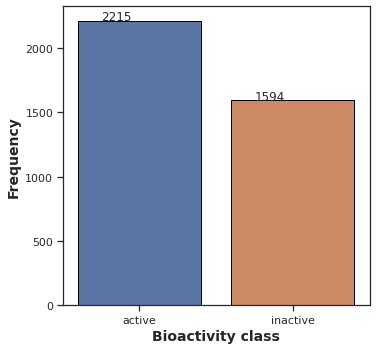

In [14]:
plt.figure(figsize=(5.5, 5.5))
ax = sns.countplot(x='class',data=df_2class,edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

plt.savefig('plot_bioactivity_class.png')

## Scatter plot of MW versus LogP

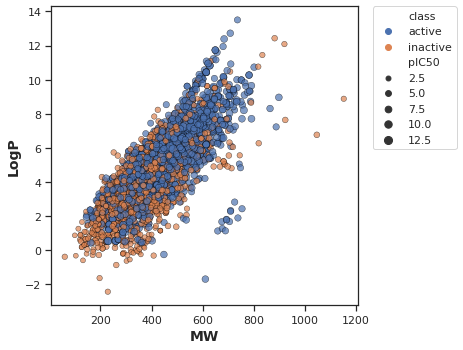

In [15]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.png')

## Box Plots

### <sub>p</sub>IC<sub>50</sub> Value

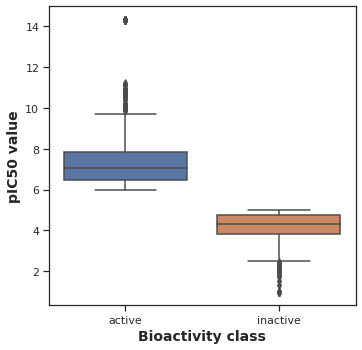

In [16]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.png')

### MW Value

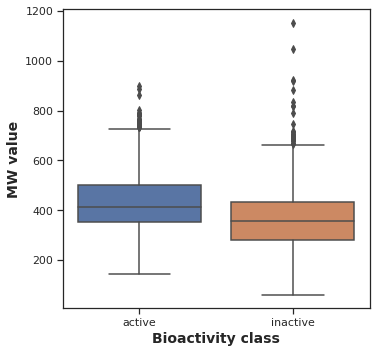

In [17]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW value', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.png')

### Log P Value

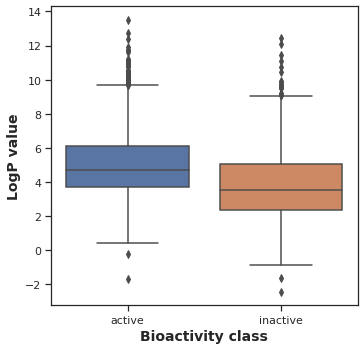

In [19]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP value', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.png') 

### NumHDonors Value

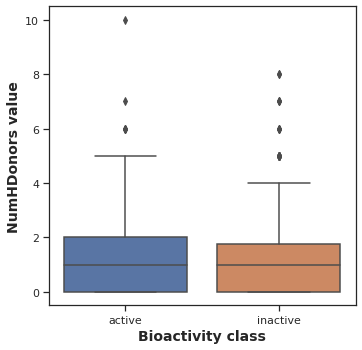

In [20]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors value', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.png') 

### NumHAcceptors Value

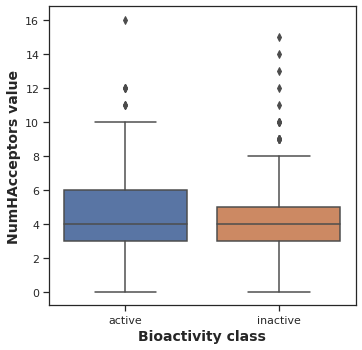

In [21]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors value', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.png') 

## Statistical Analysis: Mann-Whitney U Test

In [22]:
# Creating MannWhitney Function

def mannwhitney(descriptor, verbose=False):

  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [24]:
# MannWhitney tests 
print(mannwhitney('pIC50'))
print(mannwhitney('MW'))
print(mannwhitney('LogP'))
print(mannwhitney('NumHDonors'))
print(mannwhitney('NumHAcceptors'))

  Descriptor  Statistics    p  alpha                      Interpretation
0      pIC50         0.0  0.0   0.05  Different distribution (reject H0)
  Descriptor  Statistics  ...  alpha                      Interpretation
0         MW   1207259.5  ...   0.05  Different distribution (reject H0)

[1 rows x 5 columns]
  Descriptor  Statistics  ...  alpha                      Interpretation
0       LogP   1176292.5  ...   0.05  Different distribution (reject H0)

[1 rows x 5 columns]
   Descriptor  Statistics  ...  alpha                      Interpretation
0  NumHDonors   1524372.5  ...   0.05  Different distribution (reject H0)

[1 rows x 5 columns]
      Descriptor  Statistics  ...  alpha                      Interpretation
0  NumHAcceptors   1636225.0  ...   0.05  Different distribution (reject H0)

[1 rows x 5 columns]


## Interpretation of Statistical Results

###### **pIC50 values**

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 5 = Inactives``) were used to define actives and inactives.

###### **Lipinski's descriptors**

All of the 4 Lipinski's descriptors exhibited ***statistically significant difference*** between the **actives** and **inactives**.

In [25]:
# Zipping the results
! zip -r results.zip . -i *.csv *.png

  adding: mannwhitneyu_pIC50.csv (deflated 14%)
  adding: plot_LogP.png (deflated 12%)
  adding: mannwhitneyu_NumHAcceptors.csv (deflated 10%)
  adding: plot_NumHAcceptors.png (deflated 12%)
  adding: mannwhitneyu_MW.csv (deflated 9%)
  adding: bioactivity_class_pic50.csv (deflated 76%)
  adding: plot_bioactivity_class.png (deflated 17%)
  adding: plot_MW.png (deflated 14%)
  adding: bioactivity_2class_df.csv (deflated 77%)
  adding: plot_NumHDonors.png (deflated 13%)
  adding: mannwhitneyu_LogP.csv (deflated 8%)
  adding: mannwhitneyu_NumHDonors.csv (deflated 11%)
  adding: plot_MW_vs_LogP.png (deflated 1%)
  adding: plot_ic50.png (deflated 13%)


# **Part-3: Descriptor Calculation and Dataset Preparation**

# Pre-requisite

## Downloading Padel Descriptor

In [26]:
# Downloading the padel descriptor
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2021-05-07 09:25:10--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2021-05-07 09:25:10--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip’

padel.zip           100%[===================>]  24.57M  54.9MB/s    in 0.4s    

2021-05-07 09:25:11 (54.9 MB/s) - ‘padel.zip’ saved [25768637/25768637]

--2021-05-07 09:25:11--  https://g

In [27]:
! unzip padel.zip

Archive:  padel.zip
   creating: PaDEL-Descriptor/
  inflating: __MACOSX/._PaDEL-Descriptor  
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
   creating: PaDEL-Descriptor/license/
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/KlekotaRothFingerprintCount.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._KlekotaRothFingerprintCount.xml  
  inflating: PaDEL-Descriptor/config  
  inflating: __MACOSX/PaDEL-Descriptor/._config  
  inf

## Loading the bioactivity dataframe

In [28]:
# Importing required libraries
import pandas as pd

In [30]:
df = pd.read_csv('/content/bioactivity_class_pic50.csv')
df.drop(['Unnamed: 0'],inplace=True,axis=1)
df

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,active,312.325,2.80320,0.0,6.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,active,376.913,4.55460,0.0,5.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,inactive,426.851,5.35740,0.0,5.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,active,404.845,4.70690,0.0,5.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,active,346.334,3.09530,0.0,6.0,6.096910
...,...,...,...,...,...,...,...,...
5038,CHEMBL4554172,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4cccc(F)c4)CC3)sc2-...,inactive,499.655,7.08374,1.0,4.0,5.000000
5039,CHEMBL4533844,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C(F)(F)F)CC3...,intermediate,549.662,7.96344,1.0,4.0,5.120904
5040,CHEMBL4570655,Cc1ccc(-c2nc(NC(=O)C3CCN(Cc4ccccc4C)CC3)sc2-c2...,inactive,495.692,7.25306,1.0,4.0,5.000000
5041,CHEMBL4571704,COc1cc(O)c2c(c1)C1=C(c3c(O)c(O)cc(C)c3-c3cc(OC...,inactive,576.510,4.06432,6.0,11.0,4.809668


In [31]:
# Selecting particular columns
selection = ['canonical_smiles','molecule_chembl_id']
df_selection = df[selection]
df_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [32]:
# Viewing the first 5 rows
! cat molecule.smi | head -5

CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1	CHEMBL133897
O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1	CHEMBL336398
CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1	CHEMBL131588
O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F	CHEMBL130628
CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C	CHEMBL130478


In [33]:
# Viewing the length
! cat molecule.smi | wc -l

5043


# Calculating Fingerprint Descriptors

## Calculate PaDEL Descriptors

In [34]:
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [35]:
! bash padel.sh

Streaming output truncated to the last 5000 lines.
Processing CHEMBL45118 in molecule.smi (45/5043). Average speed: 0.38 s/mol.
Processing CHEMBL542609 in molecule.smi (46/5043). Average speed: 0.38 s/mol.
Processing CHEMBL155322 in molecule.smi (47/5043). Average speed: 0.37 s/mol.
Processing CHEMBL154211 in molecule.smi (48/5043). Average speed: 0.37 s/mol.
Processing CHEMBL1203537 in molecule.smi (49/5043). Average speed: 0.36 s/mol.
Processing CHEMBL86 in molecule.smi (50/5043). Average speed: 0.36 s/mol.
Processing CHEMBL47375 in molecule.smi (51/5043). Average speed: 0.35 s/mol.
Processing CHEMBL345849 in molecule.smi (53/5043). Average speed: 0.35 s/mol.
Processing CHEMBL542360 in molecule.smi (52/5043). Average speed: 0.35 s/mol.
Processing CHEMBL154689 in molecule.smi (54/5043). Average speed: 0.34 s/mol.
Processing CHEMBL346733 in molecule.smi (55/5043). Average speed: 0.34 s/mol.
Processing CHEMBL416464 in molecule.smi (56/5043). Average speed: 0.33 s/mol.
Processing CHEMBL1

# Preparing the Data Matrices

## X Matrix

In [36]:
# Reading the op file from padel step
df_X = pd.read_csv('descriptors_output.csv')
df_X

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL336398,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CHEMBL133897,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CHEMBL130628,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,CHEMBL131588,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,CHEMBL130478,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,CHEMBL4554172,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5039,CHEMBL4533844,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5040,CHEMBL4570655,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5041,CHEMBL4571704,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
# Dropping the name column
df_X = df_X.drop(columns=['Name'])
df_X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5039,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5040,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5041,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Y Column

In [38]:
# Using the pic50 as y column
df_Y = df['pIC50']
df_Y

0       6.124939
1       7.000000
2       4.301030
3       6.522879
4       6.096910
          ...   
5038    5.000000
5039    5.120904
5040    5.000000
5041    4.809668
5042    4.165579
Name: pIC50, Length: 5043, dtype: float64

## Combining the X and Y to prepare a dataset

In [39]:
# Concatenating X and Y variables
dataset = pd.concat([df_X,df_Y],axis=1)
dataset

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.124939
1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.000000
2,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.301030
3,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.522879
4,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.096910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.000000
5039,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.120904
5040,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.000000
5041,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.809668


In [40]:
# Saving to csv file
dataset.to_csv('bioactivity_data_class_pIC50_pubchem_fp.csv',index=False)

# **Part-4: Regression Model with Random Forest**

# Pre-requisite

## Importing libraries

In [41]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

## Loading the dataset

In [42]:
df = pd.read_csv('bioactivity_data_class_pIC50_pubchem_fp.csv')
df

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.124939
1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.000000
2,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.301030
3,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.522879
4,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.096910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.000000
5039,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.120904
5040,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.000000
5041,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.809668


# Pre-process Data

## Input features

In [43]:
X = df.drop('pIC50',axis=1)
X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5039,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5040,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5041,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Output Feature

In [44]:
Y = df.pIC50
Y

0       6.124939
1       7.000000
2       4.301030
3       6.522879
4       6.096910
          ...   
5038    5.000000
5039    5.120904
5040    5.000000
5041    4.809668
5042    4.165579
Name: pIC50, Length: 5043, dtype: float64

## Checking the data dimensions

In [45]:
# X dimension
X.shape

(5043, 881)

In [46]:
# Y dimension
Y.shape

(5043,)

## Remove low variance features

In [47]:
from sklearn.feature_selection import VarianceThreshold

selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)
X

array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0]])

# Data Split

In [48]:
# Train Test Split into 80-20
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [49]:
# Checking dimensions of train set
X_train.shape, Y_train.shape

((4034, 140), (4034,))

In [50]:
# Checking dimensions of test set
X_test.shape, Y_test.shape

((1009, 140), (1009,))

# Building a Regression Model: Random Forest

In [51]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
r2

0.5532211320295918

In [52]:
# Predicting the values using model
Y_pred = model.predict(X_test)

# Scatter Plot of Experimental vs Predicted <sub>p</sub>IC<sub>50</sub> Values

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


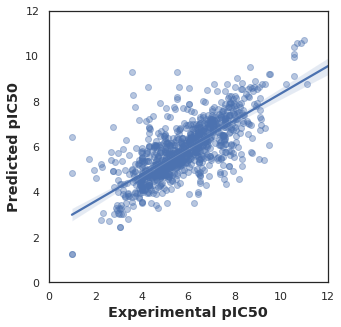

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Y_test, Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show()

# **Part-5: Comparing Regressors**

# Pre-requisite

## Installing and Importing libraries

In [54]:
# Downloading the libraries
! pip install lazypredict

     |████████████████████████████████| 81kB 4.1MB/s 
     |████████████████████████████████| 25.9MB 1.6MB/s 
     |████████████████████████████████| 307kB 45.1MB/s 
     |████████████████████████████████| 1.2MB 40.2MB/s 
     |████████████████████████████████| 6.8MB 44.2MB/s 
     |████████████████████████████████| 276kB 50.4MB/s 
     |████████████████████████████████| 256kB 42.5MB/s 
     |████████████████████████████████| 10.1MB 45.1MB/s 
     |████████████████████████████████| 14.5MB 335kB/s 
     |████████████████████████████████| 127.6MB 99kB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=d858f464dd880dc51b717ee575d0c1d12855e54cd598d97b06acdae72c7c4460
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built PyYAML
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.19.1 which is incompatible.
ERROR: google-colab 1.0.0 has requiremen

In [1]:
# Importing libraries
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import lazypredict
from lazypredict.Supervised import LazyRegressor

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


## Loading dataset

In [2]:
# Reading the dataset
df = pd.read_csv('bioactivity_data_class_pIC50_pubchem_fp.csv')
df

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.12
1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.00
2,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.30
3,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.52
4,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.00
5039,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.12
5040,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.00
5041,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.81


In [3]:
# Loading the input and output features
X = df.drop('pIC50', axis=1)
Y = df.pIC50

# Pre-processing Data

In [4]:
# Remove low variance features
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)
X.shape

(5043, 140)

In [5]:
# Perform data splitting using 80/20 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [6]:
X_train.shape, Y_train.shape

((4034, 140), (4034,))

In [11]:
X_test.shape, Y_test.shape

((1009, 140), (1009,))

# Comparing Using ML Algorithms

In [7]:
# Defines and builds the lazyclassifier
clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models_train,predictions_train = clf.fit(X_train, X_train, Y_train, Y_train)
models_test,predictions_test = clf.fit(X_train, X_test, Y_train, Y_test)

100%|██████████| 42/42 [00:00<00:00, 243652.51it/s]


In [8]:
# Performance table of the training set (80% subset)
predictions_train

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
DecisionTreeRegressor,0.86,0.87,0.58,0.18
ExtraTreeRegressor,0.86,0.87,0.58,0.16
ExtraTreesRegressor,0.86,0.87,0.58,6.52
GaussianProcessRegressor,0.86,0.87,0.58,6.07
RandomForestRegressor,0.83,0.84,0.65,5.10
XGBRegressor,0.82,0.83,0.66,2.28
BaggingRegressor,0.81,0.82,0.69,0.66
MLPRegressor,0.79,0.80,0.72,7.12
HistGradientBoostingRegressor,0.67,0.69,0.90,4.11


# Visualise the data of each model performance

## Bar-Plot of R-squared values

[(0.0, 1.0)]

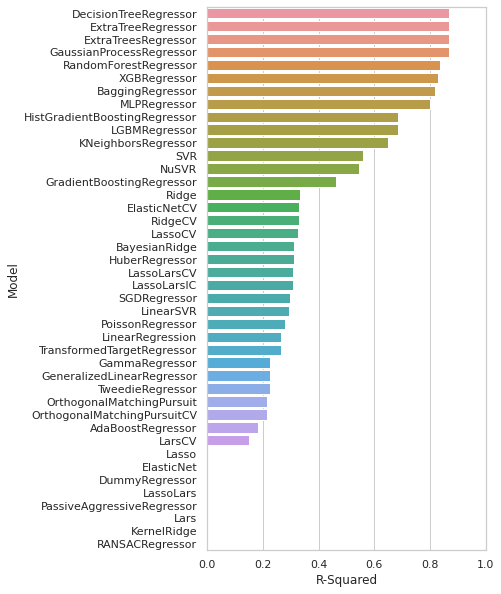

In [13]:
# Bar plot of R-squared values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="R-Squared", data=predictions_train)
ax.set(xlim=(0, 1))

## Bar-Plot of RMSE Values

[(0.0, 10.0)]

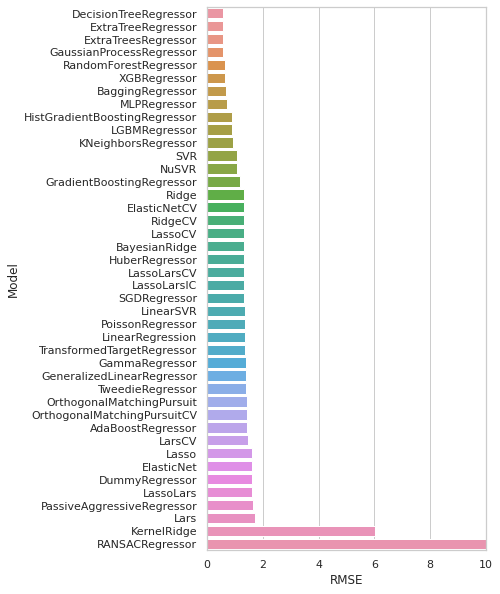

In [14]:
# Bar plot of RMSE values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="RMSE", data=predictions_train)
ax.set(xlim=(0, 10))

## Bar-Plot of Calculation Time

[(0.0, 10.0)]

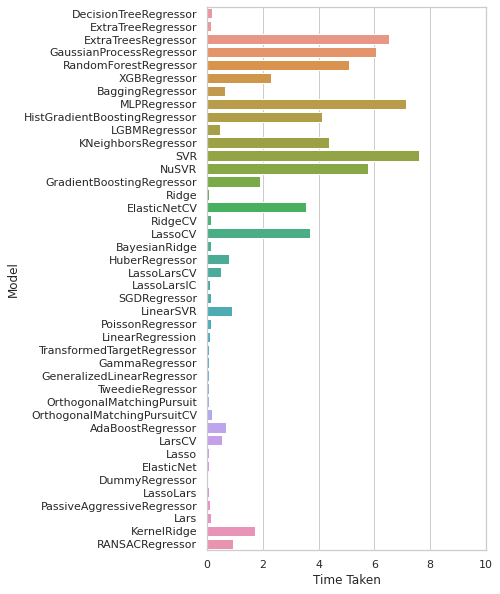

In [15]:
# Bar plot of calculation time
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_train.index, x="Time Taken", data=predictions_train)
ax.set(xlim=(0, 10))